# N-band simulation of image source

This notebook demonstrates how to run a simulation with SimMETIS when the source structure is provided in the shape of one or several images. Each image is associated with a spectrum. The resulting `Source` object can be thought of as a cube, which is the sum of the images weighted with their associated spectrum. 

In [1]:
import numpy as np
from glob import glob
from astropy.io import fits

In [2]:
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

Import SimMETIS and check the versions of required packages:

In [3]:
import simmetis as sim
sim.bug_report()

Optional package wget is not installed:
       simmetis.get_extras() will not work.
Python:
 3.9.1+ (default, Feb  5 2021, 13:46:56) 
[GCC 10.2.1 20210110]

simmetis :  0.3rc1
astropy :  4.2
synphot :  1.0.1
numpy :  1.19.4
scipy :  1.5.4
poppy could not be loaded.
wget could not be loaded.

Operating system:  Linux
         Release:  5.10.0-3-amd64
         Version:  #1 SMP Debian 5.10.13-1 (2021-02-06)
         Machine:  x86_64


The object will be observed in the N2 band. We start by setting up a `UserCommands` structure to configure SimMETIS to use the instrument setup or N-band imaging. If an L or M band observation is simulated, the LM config file needs to be uncommented.

In [4]:
cmds = sim.UserCommands('metis_image_N.config')
# cmds = sim.UserCommands("metis_image_LM.config")

## Setting up the source

The source is a simulation of an AGN torus from Schartmann et al., MNRAS, 445, 3878 (2014). It is provided in the form of an image, where pixel values are given in Jy/pixel at a wavelength of 12 micron:

In [5]:
with fits.open("../test_data/sd0615_image_l12_i090_p000.fits") as inhdul:
    sourceimg = inhdul[0].data
    sourcehdr = inhdul[0].header

print("Pixel unit:", sourcehdr['BUNIT'])
print("Wavelength:", sourcehdr['LAMBDA1'], '[m]')

Pixel unit: JY/PIXEL
Wavelength: 1.2e-05 [m]


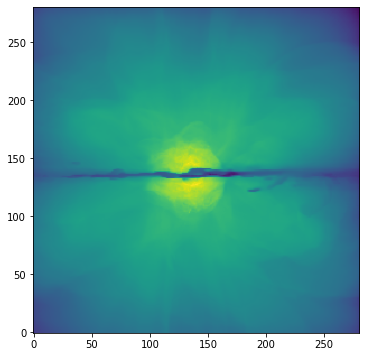

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(sourceimg[120:401, 120:401], norm=LogNorm(), origin='lower')

The pixel scale in this simulation is 0.5 mas because it was made to interpret VLTI observations:

In [7]:
print("Pixel scale:", sourcehdr['CDELT1'] * 3600)

Pixel scale: 0.000501151066291764


At this pixel scale, the source will not be resolved by METIS, we will instead assume a pixel scale of 5 mas:

In [8]:
pixscale = 0.005    # arcsec
#pixscale = sourcehdr['CDELT1'] * 3600

We have not been provided with a spectrum for this image. For simplicity we will assume a flat spectrum (in $f_{\lambda}$). As the image pixel values are in Jy/pixel and since SimMETIS operates internally with ph/(m2 s px bin), where bin is the spectral bin width, we need to calculate the conversion factor between the two. Here we compute the number of photons/(m2 s um) that correspond to 1 Jy at $\lambda_{\mathrm{ref}}$. This number is used to produce (internally) a cube. Here we set $\lambda_{\mathrm{ref}} = 12\,\mu{}\mathrm{m}$ since the simulated image we work with is at this wavelength.

In [9]:
from astropy import units as u
lam_ref = 12 * u.um
flam_ref = (1 * u.Jy).to(u.ph * u.s**-1 * u.m**-2 * u.um**-1, 
                         equivalencies=u.spectral_density(lam_ref))
print("1 Jy at {0:5.2f} corresponds to {1:5.2f}".format(lam_ref, flam_ref))

1 Jy at 12.00 um corresponds to 1257658.48 ph / (m2 s um)


SimMETIS expects the spectral flux density to be given in units of photons / (m2 s px bin):

In [10]:
dlam = 0.01  # [um], spectral bin width
lam = sim.utils.seq(10, 13.2, dlam)
flux = np.ones_like(lam) * flam_ref * dlam

We can now construct the SimMETIS `Source` object using the function `sim.source.source_from_image`. The `oversample` parameter is necessary to prevent aliasing due to the way that images are currently handled in SimMETIS.

In [11]:
src = sim.source.source_from_image(sourceimg, lam, flux, 
                                   plate_scale=pixscale, oversample=4)

# Setting up and running the simulation

List all available filters

In [12]:
filters = glob("../data/TC_filter*.dat")
for filter in filters:
    print(filter.split("/")[2])

TC_filter_PAH_3.3_ref.dat
TC_filter_N1.dat
TC_filter_N3.dat
TC_filter_short-L.dat
TC_filter_Br_alpha.dat
TC_filter_PAH_3.3.dat
TC_filter_Q1.dat
TC_filter_CO_ref.dat
TC_filter_S_IV_ref.dat
TC_filter_PAH_8.6.dat
TC_filter_N2.dat
TC_filter_CO(1-0)_ice.dat
TC_filter_Br_alpha_ref.dat
TC_filter_Mp.dat
TC_filter_Ne_II.dat
TC_filter_H2O-ice.dat
TC_filter_L.dat
TC_filter_S_IV.dat
TC_filter_PAH_11.25_ref.dat
TC_filter_open.dat
TC_filter_PAH_11.25.dat
TC_filter_PAH_8.6_ref.dat
TC_filter_IB_4.05.dat
TC_filter_Lp.dat
TC_filter_Ne_II_ref.dat


Set up the instrument to use the N2 filter:

In [13]:
cmds['INST_FILTER_TC'] = 'TC_filter_N2.dat'

Build the optical train and the detector:

In [14]:
opttrain = sim.OpticalTrain(cmds)
fpa = sim.Detector(cmds, small_fov=False)

Now apply the optical train to the source object. This creates an ideal image just in front of the detector with units of photons per second per pixel.

In [15]:
src.apply_optical_train(opttrain, fpa)

Generating image for chip 1


To create the simulated detector images we "read out" the detector with various exposure times (We could use `OBS_NDIT` to simulate a sequence of reads that would be averaged). The results are FITS HDU objects.

In [16]:
imghdu_1 = fpa.read_out(OBS_DIT=1)
imghdu_100 = fpa.read_out(OBS_DIT=100)
imghdu_3600 = fpa.read_out(OBS_DIT=3600)

Reading out chip 1 using superfast
DIT = 1    NDIT = 1.0
Reading out chip 1 using superfast
DIT = 100    NDIT = 1.0
Reading out chip 1 using superfast
DIT = 3600    NDIT = 1.0


Save the results to disk:

In [17]:
imghdu_1.writeto("sd0615_METIS_N2_1sec.fits", overwrite=True)
imghdu_100.writeto("sd0615_METIS_N2_100sec.fits", overwrite=True)
imghdu_3600.writeto("sd0615_METIS_N2_3600sec.fits", overwrite=True)

## Looking at the results

Text(0.5, 1.0, 'OBS_DIT=3600')

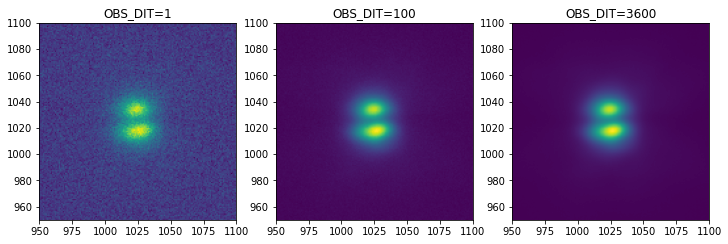

In [18]:
extent = (xmin, xmax, ymin, ymax) = (950, 1100, 950, 1100)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.imshow(imghdu_1[0].data[ymin:ymax, xmin:xmax], 
           norm=LogNorm(), origin='lower', extent=extent)
ax1.set_title("OBS_DIT=1")
ax2.imshow(imghdu_100[0].data[ymin:ymax, xmin:xmax],
          norm=LogNorm(), origin='lower', extent=extent)
ax2.set_title("OBS_DIT=100")
ax3.imshow(imghdu_3600[0].data[ymin:ymax, xmin:xmax],
           norm=LogNorm(), origin='lower', extent=extent)
ax3.set_title("OBS_DIT=3600")

Look at background and source counts for these images. We define an aperture mask of radius 100 pixels for the object: 

In [19]:
ny, nx = imghdu_1[0].data.shape
j, i = np.ogrid[0:ny, 0:nx]
icen, jcen = 1023.5, 1023.5

# apertures for source and background
srcmask = ((i - icen)**2 + (j - jcen)**2 < 100**2)  # radius 100 pixels
bgmask = np.logical_not(srcmask)
n_src = np.sum(srcmask)     # number of pixels in aperture
n_bg = np.sum(bgmask)       # number of pixels outside aperture

In [20]:
images = [imghdu_1[0].data, imghdu_100[0].data, imghdu_3600[0].data]
T_exp = np.array([1, 100, 3600])

In [21]:
bg_counts = np.array([np.mean(img[bgmask]) for img in images])
print("   T_exp     counts    counts/sec")
for T, bg in zip(T_exp, bg_counts):
    print("{:>4} sec:  {:8.4g}   {:.2f}".format(T, bg, bg / T))

   T_exp     counts    counts/sec
   1 sec:  1.592e+08   159213404.44
 100 sec:  1.592e+10   159213397.25
3600 sec:  5.732e+11   159213398.95


In [22]:
src_counts = np.array([np.sum(img[srcmask] - bg) 
                       for img, bg in zip(images, bg_counts)])
print("   T_exp     counts     counts/sec")
for T, cts in zip(T_exp, src_counts):
    print("{:>4} sec:  {:8.4g}   {:.2f}".format(T, cts, cts / T))

   T_exp     counts     counts/sec
   1 sec:  2.528e+08   252821416.22
 100 sec:  2.551e+10   255086369.28
3600 sec:  9.191e+11   255297483.21


These numbers are in agreement with E-TRE-MPIA-MET-0004 ("Detector flux levels in METIS") v0.8 by Roy van Boekel.

## Varying airmasses

The images above were simulated for airmass 1.0. We will now vary airmass at a fixed exposure time of 3600 s:

In [23]:
airmass = [1.0, 1.3, 2.0]

In [24]:
hdus_am = []
opttrains = []
for airm in airmass:
    print("Working on airmass", airm)
    cmds['ATMO_AIRMASS'] = airm
    opttrains.append(sim.OpticalTrain(cmds))
    fpa = sim.Detector(cmds, small_fov=False)
    src.apply_optical_train(opttrains[-1], fpa)
    hdus_am.append(fpa.read_out(OBS_DIT=3600.))
    hdus_am[-1].writeto("sd0615_METIS_N2_3600_" + str(airm) + ".fits", overwrite=True)

Working on airmass 1.0
Generating image for chip 1
Reading out chip 1 using superfast
DIT = 3600.0    NDIT = 1.0
Working on airmass 1.3
Generating image for chip 1
Reading out chip 1 using superfast
DIT = 3600.0    NDIT = 1.0
Working on airmass 2.0
Generating image for chip 1
Reading out chip 1 using superfast
DIT = 3600.0    NDIT = 1.0


In [25]:
images_am = [hdu[0].data for hdu in hdus_am]
background_am = [np.mean(img[bgmask]) for img in images_am]
print("airmass   bg.counts")
for airm, bg in zip(airmass, background_am):
    print("{:.1f}      {:.5g}".format(airm, bg))

airmass   bg.counts
1.0      5.7317e+11
1.3      5.8809e+11
2.0      6.1886e+11


In [26]:
src_am = [np.sum(img[srcmask] - bg) for img, bg in zip(images_am, background_am)]
print("airmass   src.counts")
for airm, ct in zip(airmass, src_am):
    print("{:.1f}        {:.4g}".format(airm, ct))

airmass   src.counts
1.0        9.189e+11
1.3        9.087e+11
2.0        8.857e+11


As expected, the number of background counts is increased as airmass increases while the number of source counts decreases. The latter only decreases slightly because the atmospheric transmission is relatively good in this filter.